In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tnrange, tqdm_notebook

from causal_meta.utils.data_utils import generate_data_categorical
from models import StructuralModel

In [3]:
N = 10
model = StructuralModel(N, dtype=torch.float64)

In [4]:
optimizer = torch.optim.SGD(model.modules_parameters(), lr=1e-1)
meta_optimizer = torch.optim.RMSprop([model.w], lr=1e-2)

In [5]:
num_runs = 1 # 10
num_training = 1 # 100
num_transfer = 1000
num_gradient_steps = 2

train_batch_size = 1000
transfer_batch_size = 10

In [6]:
alphas = np.zeros((num_runs, num_training, num_transfer))

for j in tnrange(num_runs):
    model.w.data.zero_()
    for i in tnrange(num_training, leave=False):
        # Step 1: Sample a joint distribution before intervention
        pi_A_1 = np.random.dirichlet(np.ones(N))
        pi_B_A = np.random.dirichlet(np.ones(N), size=N)
        
        transfers = tnrange(num_transfer, leave=False)
        for k in transfers:
            # Step 2: Train the modules on the training distribution
            model.set_ground_truth(pi_A_1, pi_B_A)
            # Step 3: Sample a joint distribution after intervention
            pi_A_2 = np.random.dirichlet(np.ones(N))

            # Step 4: Do k steps of gradient descent for adaptation on the
            # distribution after intervention
            model.zero_grad()
            loss = torch.tensor(0., dtype=torch.float64)
            for _ in range(num_gradient_steps):
                x_train = torch.from_numpy(generate_data_categorical(transfer_batch_size, pi_A_2, pi_B_A))
                loss += -torch.mean(model(x_train))
                optimizer.zero_grad()
                inner_loss_A_B = -torch.mean(model.model_A_B(x_train))
                inner_loss_B_A = -torch.mean(model.model_B_A(x_train))
                inner_loss = inner_loss_A_B + inner_loss_B_A
                inner_loss.backward()
                optimizer.step()

            # Step 5: Update the structural parameter alpha
            meta_optimizer.zero_grad()
            loss.backward()
            meta_optimizer.step()

            # Log the values of alpha
            alpha = torch.sigmoid(model.w).item()
            alphas[j, i, k] = alpha
            transfers.set_postfix(alpha='{0:.4f}'.format(alpha), grad='{0:.4f}'.format(model.w.grad.item()))

C:\Users\rocho\anaconda3\envs\RNN-TDI\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\rocho\anaconda3\envs\RNN-TDI\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


C:\Users\rocho\anaconda3\envs\RNN-TDI\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # Remove the CWD from sys.path while we load stuff.


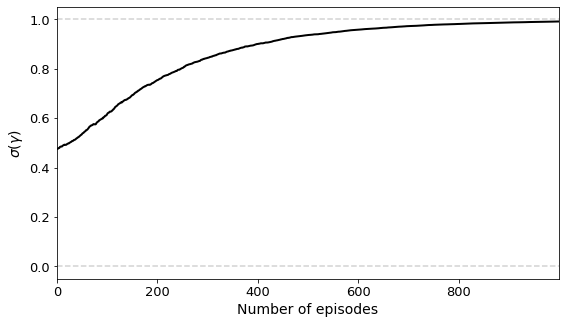

In [7]:
alphas_50 = np.percentile(alphas.reshape((-1, num_transfer)), 50, axis=0)

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
ax.plot(alphas_50, lw=2, color='k')

ax.set_xlim([0, num_transfer - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)

plt.show()